# Импорт необходимых библиотек

In [ ]:
import numpy as np
import pandas as pd

import optuna
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from string import punctuation
import spacy
from langdetect import detect

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

import tensorflow as tf
import tensorflow_addons as tfa

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, GlobalMaxPooling1D, Dropout, Embedding, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

from keras.models import save_model

C:\Users\User\anaconda3\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
nltk.download('stopwords')

nlp_eng = spacy.load('en_core_web_sm', disable=['ner', 'parser'])
nlp_rus = spacy.load('ru_core_news_sm', disable=['ner', 'parser'])

stop_words_rus = stopwords.words('russian')
stop_words_eng = stopwords.words('english')
stop_words = stop_words_rus+stop_words_eng+['шт', 'каждый день', 'каждый', 'день', 'красная цена', 'красная', 'цена', 'верный', 'дикси', 'моя', 'моя цена', 'окей','то, что надо!', 'smart','spar', 'ашан']

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Необходимые функции

## Функция фильтрации текстов покупок

In [ ]:
def filter_text(data):

    filtered_data = data.copy()

    selected_posts = []
    all_sentences = []

    for index in range(len(filtered_data["sale"])):
        value = filtered_data.loc[index, "sale"]
        try:
            lang = detect(value)

            if lang == 'en':
                doc = nlp_eng(value)
                lemmas = [token.lemma_ for token in doc if token.is_alpha and token.text not in punctuation]
                cleaned_sentence = ' '.join(lemmas)
                filtered_data.loc[index, 'cleaned_sale'] = cleaned_sentence
            else:
                doc = nlp_rus(value)
                lemmas = [token.lemma_ for token in doc if token.is_alpha and token.text not in punctuation]
                cleaned_sentence = ' '.join(lemmas)
                filtered_data.loc[index, 'cleaned_sale'] = cleaned_sentence
        except Exception as e:
            print(f"Error processing value: {value}")
            print(f"Error message: {str(e)}")

    filtered_data = filtered_data.dropna(subset=['cleaned_sale'])

    return filtered_data

In [ ]:
def create_model(params):

    model = Sequential()
    model.add(Embedding(2000, params['embedding_size'], input_length=29))
    model.add(LSTM(params['lstm_units'], return_sequences=True))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(params['dropout_rate']))
    model.add(Dense(params['dense_units'], activation='relu'))
    model.add(Dropout(params['dropout_rate']))
    model.add(Dense(topics, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=params['lr']),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy',
                       tfa.metrics.F1Score(num_classes=topics, average="micro")])

    return model

In [ ]:
def objective(trial):
    params = {
        'embedding_size': trial.suggest_int('embedding_size', 64, 256),
        'lstm_units': trial.suggest_int('lstm_units', 32, 128),
        'dropout_rate': trial.suggest_float('dropout_rate', 0.1, 0.5),
        'dense_units': trial.suggest_int('dense_units', 32, 128),
        'lr': trial.suggest_float('lr', 1e-4, 1e-2, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [16, 32, 64, 128]),
        'epochs': trial.suggest_int('epochs', 1, 10)
    }

    # Используем KFold для разделения данных на n_splits фолдов
    n_splits = 5
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    f1_scores = []

    f1_scores = []
    for train_index, val_index in kf.split(X_train_padded, y_train):
        X_train_fold, X_val_fold = X_train_padded[train_index], X_train_padded[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        model = create_model(params)
        model.fit(X_train_fold, y_train_fold, batch_size=params['batch_size'], epochs=params['epochs'], verbose=0, validation_data=(X_val_fold, y_val_fold))

        y_pred = np.argmax(model.predict(X_val_fold), axis=1)

        f1_scores.append(f1_score(y_val_fold, y_pred, average='micro'))

    print(f"Average F1-Score: {np.mean(f1_scores):.4f}")

    return np.mean(f1_scores)

# Подготовка датасета

## Импорт и фильтрация

In [ ]:
df2 = pd.read_excel('sales_2 (Rus).xlsx', sheet_name='Sheet1')

Удаляем очищенные предложения из прошлой итерации

In [ ]:
df2 = df2.drop(columns = ['cleaned_sale'])

Получаем новую колонку с фильтрацией

In [ ]:
sampled_df = filter_text(df2)

In [ ]:
sampled_df.to_csv('sampled_df_filtred.csv')

In [ ]:
display(sampled_df)

,sale,category,price,client,topic,cleaned_sale
0,"Сыр полутвердый то, что надо! голландский 45% ...",1363498391,149,Гусев Сергей Николаевич,продукты питания,сыр полутвердый то что надо голландский г
1,Биотворог детский фрутоняня клубника-банан-ябл...,1363498391,46,Зеваков Сергей Сергеевич,продукты питания,биотворог детский фрутоняня клубника банан яблоко
2,Отбеливатель vanish oxi advance мультисила для...,1466964349,600,Балашов Михаил Васильевич,уборка,отбеливатель vanish oxi advance мультисила для...
3,От мечты до реальности. добро пожаловать в мой...,1310763416,925,Гужвин Дмитрий Викторович,образование,от мечта до реальность добро пожаловать в мой мир
4,Щербет о'кей арахисовый 250 г,1363498391,59,Филиппова Анна Петровна,продукты питания,щербет арахисовый г
...,...,...,...,...,...,...
9979,Йогурт питьевой bio баланс злаки 1% 270 мл,1363498391,63,Ковалев Иван Корнеевич,продукты питания,йогурт питьевой bio баланс злаки мл
9980,Конфеты неглазированные россия - щедрая душа! ...,1363498391,199,Матюгин Алексей Николаевич,продукты питания,конфета неглазированный россия щедрый душа родные
9981,Огурцы луховицкие,1363498391,39,Мельникова Ольга Сергеевна,продукты питания,огурец луховицкий
9982,C# для чайников,1397346122,2945,Брусов Алексей Николаевич,образование,c для чайник


In [ ]:
sampled_df.groupby('topic')['topic'].count()

topic
автозапчасти           626
аквариум               577
видеоигры              628
закуски и приправы    1121
напитки               1466
образование            603
одежда                 268
продукты питания      2381
уборка                1699
электроника            615
Name: topic, dtype: int64

In [ ]:
dictionary = {
    "topic": ['автозапчасти', 'видеоигры', 'напитки', 'продукты питания', 'закуски и приправы', 'аквариум', 'одежда', 'уборка', 'электроника', 'образование'],
    "label": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}

In [ ]:
topics = len(dictionary['topic'])

Получаем список клиентов, которых нет в нашем датасете, чтобы провести по ним тест

In [ ]:
original_df = pd.read_excel('final_df.xlsx', sheet_name='Sheet1')

In [ ]:
sam_clients = set(sampled_df['client'].unique())
all_clients = set(original_df['client'].unique())
cl=all_clients-sam_clients

In [ ]:
cl

{'Миронов Александр Викторович',
 'Чурганова Екатерина Григорьевна',
 'Леликов Александр Михайлович',
 'Конюх Ольга Ивановна',
 'Медведев Виктор Владимирович',
 'Холопов Алексей Николаевич',
 'Косоуров Александр Сергеевич',
 'Кузовкина Екатерина Игнатьевна',
 'Киняшова Людмила Станиславовна',
 'Морозов Анатолий Иванович',
 'Прозоров Анатолий Александрович',
 'Каширина Ирина Викторовна',
 'Даньшин Анатолий Семенович',
 'Симанов Дмитрий Александрович',
 'Тарасова Людмила Николаевна',
 'Леонова Дарья Андреевна',
 'Котов Роман Васильевич',
 'Шарапов Марк Юрьевич',
 'Ульянова Мария Ивановна',
 'Воронина Ирина Валерьевна',
 'Самолетов Борис Васильевич',
 'Шибаева Валентина Григорьевна',
 'Зинина Оксана Сергеевна',
 'Котович Елена Юрьевна',
 'Куличихина Любовь Анатольевна',
 'Бутенко Николай Федорович',
 'Урусова Наталья Сергеевна',
 'Кузьмин Александр Михайлович',
 'Бутузова Мария Игоревна',
 'Малахова Мария Александровна',
 'Кислякова Татьяна Ивановна',
 'Мухина Раиса Тихоновна',
 'Епифанце

## Создание фичей и таргета

In [ ]:
sampled_df = sampled_df.dropna(subset=['cleaned_sale'])
X=sampled_df['cleaned_sale']
y=sampled_df['topic']

In [ ]:
mapping_dict = dict(zip(dictionary["topic"], dictionary["label"]))
y = y.map(mapping_dict)

In [ ]:
X = X.reset_index(drop=True).to_numpy()
y = y.reset_index(drop=True).to_numpy()

In [ ]:
vectorizer = TfidfVectorizer()
f = vectorizer.fit_transform(X)
print(f"Number of unique words/features: {len(vectorizer.get_feature_names_out())}")

Number of unique words/features: 5453


In [ ]:
longest_sentence_length = max(len(sentence.split()) for sentence in X)
print(f"The longest sentence has {longest_sentence_length} words.")

The longest sentence has 21 words.


Разделение выборок

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Токенизация

In [ ]:
tokenizer = Tokenizer(num_words=2000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(X_train_seq, maxlen=29, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=29, padding='post')

## Запуск обучения

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

best_params = study.best_params
print(f"Лучшие параметры: {best_params}")

[I 2023-10-13 12:54:38,897] A new study created in memory with name: no-name-d7716b51-374f-4c1b-b9c0-ef5862a075c1


47/47 [==============================] - 0s 5ms/step


[I 2023-10-13 12:57:11,317] Trial 0 finished with value: 0.9758287380279027 and parameters: {'embedding_size': 202, 'lstm_units': 42, 'dropout_rate': 0.21844054737916063, 'dense_units': 113, 'lr': 0.009227539768278413, 'batch_size': 16, 'epochs': 10}. Best is trial 0 with value: 0.9758287380279027.


Average F1-Score: 0.9758
47/47 [==============================] - 1s 6ms/step


[I 2023-10-13 13:00:22,657] Trial 1 finished with value: 0.6359446083979262 and parameters: {'embedding_size': 206, 'lstm_units': 103, 'dropout_rate': 0.4143275104059775, 'dense_units': 34, 'lr': 0.00010773869144213359, 'batch_size': 128, 'epochs': 10}. Best is trial 0 with value: 0.9758287380279027.


Average F1-Score: 0.6359
47/47 [==============================] - 1s 8ms/step


[I 2023-10-13 13:01:43,561] Trial 2 finished with value: 0.9707526312081217 and parameters: {'embedding_size': 79, 'lstm_units': 115, 'dropout_rate': 0.4205873180383185, 'dense_units': 106, 'lr': 0.006603698790075302, 'batch_size': 32, 'epochs': 2}. Best is trial 0 with value: 0.9758287380279027.


Average F1-Score: 0.9708
47/47 [==============================] - 0s 5ms/step


[I 2023-10-13 13:04:26,608] Trial 3 finished with value: 0.9797010130630642 and parameters: {'embedding_size': 148, 'lstm_units': 47, 'dropout_rate': 0.2611867058839745, 'dense_units': 44, 'lr': 0.004860658420376548, 'batch_size': 16, 'epochs': 8}. Best is trial 3 with value: 0.9797010130630642.


Average F1-Score: 0.9797
47/47 [==============================] - 0s 4ms/step


[I 2023-10-13 13:06:45,413] Trial 4 finished with value: 0.9712881035769805 and parameters: {'embedding_size': 82, 'lstm_units': 65, 'dropout_rate': 0.14964268404739572, 'dense_units': 37, 'lr': 0.000667924084580226, 'batch_size': 16, 'epochs': 7}. Best is trial 3 with value: 0.9797010130630642.


Average F1-Score: 0.9713
47/47 [==============================] - 1s 9ms/step


[I 2023-10-13 13:07:15,104] Trial 5 finished with value: 0.8888900185774308 and parameters: {'embedding_size': 236, 'lstm_units': 35, 'dropout_rate': 0.22165382034629913, 'dense_units': 89, 'lr': 0.0008272107903617467, 'batch_size': 32, 'epochs': 1}. Best is trial 3 with value: 0.9797010130630642.


Average F1-Score: 0.8889
47/47 [==============================] - 1s 7ms/step


[I 2023-10-13 13:09:26,266] Trial 6 finished with value: 0.9780985201377387 and parameters: {'embedding_size': 70, 'lstm_units': 80, 'dropout_rate': 0.420608064812238, 'dense_units': 60, 'lr': 0.007899120549799573, 'batch_size': 64, 'epochs': 5}. Best is trial 3 with value: 0.9797010130630642.


Average F1-Score: 0.9781
47/47 [==============================] - 1s 15ms/step


[I 2023-10-13 13:14:37,831] Trial 7 finished with value: 0.8916897435279996 and parameters: {'embedding_size': 182, 'lstm_units': 119, 'dropout_rate': 0.12746723888344846, 'dense_units': 65, 'lr': 0.00015135140598617063, 'batch_size': 32, 'epochs': 4}. Best is trial 3 with value: 0.9797010130630642.


Average F1-Score: 0.8917
47/47 [==============================] - 1s 13ms/step


[I 2023-10-13 13:21:12,390] Trial 8 finished with value: 0.970084806907986 and parameters: {'embedding_size': 173, 'lstm_units': 111, 'dropout_rate': 0.25937806318388, 'dense_units': 70, 'lr': 0.0006089514337753278, 'batch_size': 32, 'epochs': 5}. Best is trial 3 with value: 0.9797010130630642.


Average F1-Score: 0.9701
47/47 [==============================] - 0s 4ms/step


[I 2023-10-13 13:21:45,373] Trial 9 finished with value: 0.2402515756925511 and parameters: {'embedding_size': 112, 'lstm_units': 50, 'dropout_rate': 0.3274479546529049, 'dense_units': 86, 'lr': 0.0003325282425643235, 'batch_size': 64, 'epochs': 1}. Best is trial 3 with value: 0.9797010130630642.


Average F1-Score: 0.2403
47/47 [==============================] - 1s 7ms/step


[I 2023-10-13 13:25:40,562] Trial 10 finished with value: 0.9790330103910536 and parameters: {'embedding_size': 131, 'lstm_units': 62, 'dropout_rate': 0.3334479013249979, 'dense_units': 51, 'lr': 0.0032315976520297866, 'batch_size': 16, 'epochs': 8}. Best is trial 3 with value: 0.9797010130630642.


Average F1-Score: 0.9790
47/47 [==============================] - 1s 7ms/step


[I 2023-10-13 13:29:33,753] Trial 11 finished with value: 0.9801016362943956 and parameters: {'embedding_size': 133, 'lstm_units': 62, 'dropout_rate': 0.3272424920171542, 'dense_units': 47, 'lr': 0.0027596805323253605, 'batch_size': 16, 'epochs': 8}. Best is trial 11 with value: 0.9801016362943956.


Average F1-Score: 0.9801
47/47 [==============================] - 1s 10ms/step


[I 2023-10-13 13:36:14,898] Trial 12 finished with value: 0.9815707070571941 and parameters: {'embedding_size': 131, 'lstm_units': 82, 'dropout_rate': 0.313684100761785, 'dense_units': 46, 'lr': 0.002469904542236862, 'batch_size': 16, 'epochs': 8}. Best is trial 12 with value: 0.9815707070571941.


Average F1-Score: 0.9816
47/47 [==============================] - 1s 10ms/step


[I 2023-10-13 13:42:24,180] Trial 13 finished with value: 0.9793003898317331 and parameters: {'embedding_size': 115, 'lstm_units': 89, 'dropout_rate': 0.4980828953468544, 'dense_units': 53, 'lr': 0.0020742797995861833, 'batch_size': 16, 'epochs': 7}. Best is trial 12 with value: 0.9815707070571941.


Average F1-Score: 0.9793
47/47 [==============================] - 1s 8ms/step


[I 2023-10-13 13:47:23,632] Trial 14 finished with value: 0.9805019919679145 and parameters: {'embedding_size': 147, 'lstm_units': 79, 'dropout_rate': 0.34436679159700345, 'dense_units': 74, 'lr': 0.001715623747983343, 'batch_size': 128, 'epochs': 9}. Best is trial 12 with value: 0.9815707070571941.


Average F1-Score: 0.9805
47/47 [==============================] - 1s 12ms/step


[I 2023-10-13 13:54:53,829] Trial 15 finished with value: 0.981570171941569 and parameters: {'embedding_size': 160, 'lstm_units': 85, 'dropout_rate': 0.3681233802811695, 'dense_units': 76, 'lr': 0.001542414547714173, 'batch_size': 128, 'epochs': 9}. Best is trial 12 with value: 0.9815707070571941.


Average F1-Score: 0.9816
47/47 [==============================] - 1s 10ms/step


[I 2023-10-13 13:59:07,170] Trial 16 finished with value: 0.9703527214642904 and parameters: {'embedding_size': 103, 'lstm_units': 95, 'dropout_rate': 0.39842552658101754, 'dense_units': 94, 'lr': 0.001341585337494106, 'batch_size': 128, 'epochs': 6}. Best is trial 12 with value: 0.9815707070571941.


Average F1-Score: 0.9704
47/47 [==============================] - 1s 15ms/step


[I 2023-10-13 14:06:21,291] Trial 17 finished with value: 0.9817041292197212 and parameters: {'embedding_size': 249, 'lstm_units': 89, 'dropout_rate': 0.36582088468402657, 'dense_units': 122, 'lr': 0.001251218550354602, 'batch_size': 128, 'epochs': 9}. Best is trial 17 with value: 0.9817041292197212.


Average F1-Score: 0.9817
47/47 [==============================] - 1s 16ms/step


[I 2023-10-13 14:12:44,299] Trial 18 finished with value: 0.9801013687365832 and parameters: {'embedding_size': 249, 'lstm_units': 101, 'dropout_rate': 0.3008811742984287, 'dense_units': 126, 'lr': 0.003889583975158961, 'batch_size': 128, 'epochs': 9}. Best is trial 17 with value: 0.9817041292197212.


Average F1-Score: 0.9801
47/47 [==============================] - 1s 11ms/step


[I 2023-10-13 14:17:07,288] Trial 19 finished with value: 0.9805018135960395 and parameters: {'embedding_size': 225, 'lstm_units': 74, 'dropout_rate': 0.3734966277862675, 'dense_units': 128, 'lr': 0.0010619907224969764, 'batch_size': 64, 'epochs': 7}. Best is trial 17 with value: 0.9817041292197212.


Average F1-Score: 0.9805
Лучшие параметры: {'embedding_size': 249, 'lstm_units': 89, 'dropout_rate': 0.36582088468402657, 'dense_units': 122, 'lr': 0.001251218550354602, 'batch_size': 128, 'epochs': 9}


Получили фантастические 98 процентов. Проверим модель на тесте.

# Проверка модели на тесте и сохранение

In [ ]:
model = create_model(best_params)
model.fit(X_train_padded, y_train, batch_size=best_params['batch_size'], epochs=best_params['epochs'], verbose=1)

Epoch 1/9
59/59 [==============================] - 11s 170ms/step - loss: 1.8274 - accuracy: 0.3677 - f1_score: 0.1953
Epoch 2/9
59/59 [==============================] - 10s 170ms/step - loss: 0.5026 - accuracy: 0.8562 - f1_score: 0.1953
Epoch 3/9
59/59 [==============================] - 10s 170ms/step - loss: 0.1747 - accuracy: 0.9583 - f1_score: 0.1953
Epoch 4/9
59/59 [==============================] - 10s 170ms/step - loss: 0.0944 - accuracy: 0.9798 - f1_score: 0.1953
Epoch 5/9
59/59 [==============================] - 10s 171ms/step - loss: 0.0735 - accuracy: 0.9834 - f1_score: 0.1953
Epoch 6/9
59/59 [==============================] - 10s 170ms/step - loss: 0.0582 - accuracy: 0.9872 - f1_score: 0.1953
Epoch 7/9
59/59 [==============================] - 10s 170ms/step - loss: 0.0467 - accuracy: 0.9894 - f1_score: 0.1953
Epoch 8/9
59/59 [==============================] - 10s 170ms/step - loss: 0.0384 - accuracy: 0.9904 - f1_score: 0.1953
Epoch 9/9
59/59 [==============================]

## Прогноз и вычисление необходимых метрик

In [ ]:
y_pred = model.predict(X_test_padded)
y_pred_classes = np.argmax(y_pred, axis=1)

acc = accuracy_score(y_test, y_pred_classes)

precision = precision_score(y_test, y_pred_classes, average='weighted')

recall = recall_score(y_test, y_pred_classes, average='weighted')

f1 = f1_score(y_test, y_pred_classes, average='weighted')

print(f"Общая точность на тестовом наборе данных: {acc*100:.2f}%")
print(f"Точность (Precision) на тестовом наборе данных: {precision*100:.2f}%")
print(f"Полнота (Recall) на тестовом наборе данных: {recall*100:.2f}%")
print(f"F1-мера на тестовом наборе данных: {f1*100:.2f}%")

78/78 [==============================] - 1s 13ms/step
Общая точность на тестовом наборе данных: 98.40%
Точность (Precision) на тестовом наборе данных: 98.46%
Полнота (Recall) на тестовом наборе данных: 98.40%
F1-мера на тестовом наборе данных: 98.41%


## Вычисление и визуализации матрицы ошибок

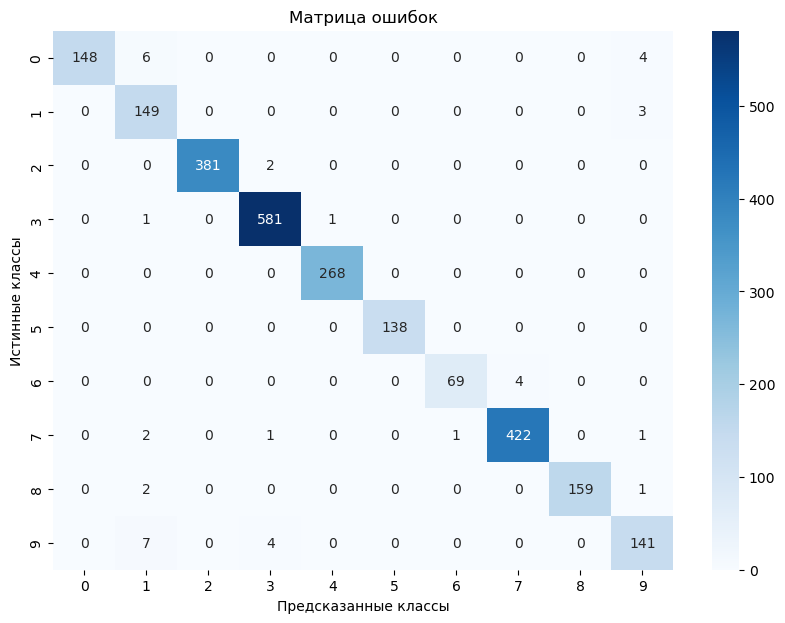

In [ ]:
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Предсказанные классы')
plt.ylabel('Истинные классы')
plt.title('Матрица ошибок')
plt.show()

## Сохранение модели и токенизатора

In [ ]:
with open('LSTM_tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

In [ ]:
model.save("LSTM_model.h5")

C:\Users\User\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
